# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTMx/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [11]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTMx/"

In [12]:
seq_length = 26
train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [13]:
train_Xs.shape, train_ys.shape

((754, 26, 4), (754, 1, 4))

In [14]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [15]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [16]:
train_Xs = np.concatenate([train_Xs[:,:,0:1], train_Xs[:,:,-2:-1]], axis = 2)
val_Xs = np.concatenate([val_Xs[:,:,0:1], val_Xs[:,:,-2:-1]], axis = 2)

In [17]:
train_ys = np.concatenate([train_ys[:,:,0:1], train_ys[:,:,-2:-1]], axis = 2)
val_ys = np.concatenate([val_ys[:,:,0:1], val_ys[:,:,-2:-1]], axis = 2)

In [18]:
train_Xs.shape, val_Xs.shape, train_ys.shape, val_ys.shape

((603, 26, 2), (151, 26, 2), (603, 1, 2), (151, 1, 2))

In [19]:
trn_xs_tensor = torch.Tensor(train_Xs)
trn_ys_tensor = torch.Tensor(train_ys)

val_xs_tensor = torch.Tensor(val_Xs)
val_ys_tensor = torch.Tensor(val_ys)

In [20]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([603, 26, 2]),
 torch.Size([603, 1, 2]),
 torch.Size([151, 26, 2]),
 torch.Size([151, 1, 2]))

In [21]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [22]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
2 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
3 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
4 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
5 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
6 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
7 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
8 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
9 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
10 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
11 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
12 torch.Size([3, 26, 2]) torch.Size([3, 1, 2])


In [23]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
2 torch.Size([50, 26, 2]) torch.Size([50, 1, 2])
3 torch.Size([1, 26, 2]) torch.Size([1, 1, 2])


In [24]:
#train_ts_df = train_df["Flucases"]
#train_ys_df = train_df[["Tempave", "Rh"]]
#train_xs_df = train_df["Holiday"]

#train_np = np.concatenate([train_ts_np.reshape(-1,1), train_ys_np, train_xs_np.reshape(-1,1)], axis = 1)

# LSTM model

In [25]:
class cLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_size=32, cond_size = 1, output_size=4, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cond_size = cond_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.cfc1 = nn.Linear(self.cond_size, int(self.hidden_size / 2))
        self.cfc2 = nn.Linear(int(self.hidden_size / 2), int(self.hidden_size / 4))
        
        self.fc1 = nn.Linear(int(self.hidden_size / 4) + self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x, cin):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        
        ch1 = self.relu(self.cfc1(cin))
        ch2 = self.cfc2(ch1)
        
        h_list = [outs, ch2]
        h1 = torch.cat(h_list, dim=1)
        h2 = self.relu(self.fc1(h1))
        y = self.relu(self.fc2(h2))
        
        return y

In [26]:
model = cLSTM(input_size = 2, hidden_size = 16, cond_size = 1, output_size = 1, num_layers = 1)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
model

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 16, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=8, bias=True)
  (cfc2): Linear(in_features=8, out_features=4, bias=True)
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Prediction

In [28]:
batch_0x = list(trn_loader)[0][0]
batch_0c = list(trn_loader)[0][1]

In [29]:
batch_0x.shape, batch_0c.shape

(torch.Size([50, 26, 2]), torch.Size([50, 1, 2]))

In [30]:
batch_0c = torch.reshape(batch_0c[:,:,-1], (batch_0c.shape[0], 1))

In [31]:
preds = model(batch_0x, batch_0c)

In [32]:
batch_0c.shape

torch.Size([50, 1])

In [33]:
preds = model(batch_0x, batch_0c)

In [34]:
preds.shape

torch.Size([50, 1])

## Train

In [35]:
model.cuda()

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 16, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=8, bias=True)
  (cfc2): Linear(in_features=8, out_features=4, bias=True)
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()
                input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
                true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))

            pred = model(inputs, input_c)
            pred = pred.reshape(true_y.shape)
            loss = criterion(pred, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [38]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
        true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))
        
        optimizer.zero_grad()
        
        pred = model(inputs, input_c)
        pred = pred.reshape(true_y.shape)
        loss = criterion(pred, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.7615177556872368 Val loss:  0.6209522532299161
epoch:  1 Train loss:  0.7082289961668161 Val loss:  0.5872243149206042
epoch:  2 Train loss:  0.7981159331706854 Val loss:  0.5407330738380551
epoch:  3 Train loss:  0.6154666892611064 Val loss:  0.4772795643657446
epoch:  4 Train loss:  0.5250230345588464 Val loss:  0.392647878266871
epoch:  5 Train loss:  0.43178662944298524 Val loss:  0.3044278030283749
epoch:  6 Train loss:  0.32062047347426414 Val loss:  0.22046739887446165
epoch:  7 Train loss:  0.2487702008623343 Val loss:  0.15174722496885806
epoch:  8 Train loss:  0.16990026401785704 Val loss:  0.10760918899904937
epoch:  9 Train loss:  0.12973333003285986 Val loss:  0.08666296602859802
epoch:  10 Train loss:  0.15377804035177597 Val loss:  0.08315622315149085
epoch:  11 Train loss:  0.10776481132667798 Val loss:  0.08665834087878466
epoch:  12 Train loss:  0.12033749601015678 Val loss:  0.08533366903429851
epoch:  13 Train loss:  0.11369772656605794 Val 

epoch:  112 Train loss:  0.08930816469588675 Val loss:  0.0883781430311501
epoch:  113 Train loss:  0.09133646923762101 Val loss:  0.0890067326836288
epoch:  114 Train loss:  0.08987444160895673 Val loss:  0.09001169865950942
epoch:  115 Train loss:  0.08958890640105192 Val loss:  0.08966998988762498
epoch:  116 Train loss:  0.0892265890366756 Val loss:  0.08889284776523709
epoch:  117 Train loss:  0.09091421759484757 Val loss:  0.08987825782969594
epoch:  118 Train loss:  0.09682826826778743 Val loss:  0.08956631551700411
epoch:  119 Train loss:  0.09703334234654903 Val loss:  0.09249009334598668
epoch:  120 Train loss:  0.0927916311730559 Val loss:  0.09023315325612202
epoch:  121 Train loss:  0.10169571394530627 Val loss:  0.08910861682488758
epoch:  122 Train loss:  0.09389314256035365 Val loss:  0.09625939384568483
epoch:  123 Train loss:  0.09181376509010218 Val loss:  0.09295075856789481
epoch:  124 Train loss:  0.09588408341201451 Val loss:  0.09114590224226049
epoch:  125 Trai

epoch:  224 Train loss:  0.08961980489010994 Val loss:  0.08689596242817288
epoch:  225 Train loss:  0.08815082621115905 Val loss:  0.08759177859610645
epoch:  226 Train loss:  0.0898982621012972 Val loss:  0.0883966028445684
epoch:  227 Train loss:  0.08891180945703617 Val loss:  0.08752489259495633
epoch:  228 Train loss:  0.08496498717711522 Val loss:  0.08809381906758063
epoch:  229 Train loss:  0.08521901508076833 Val loss:  0.08992740886969841
epoch:  230 Train loss:  0.0850864139994463 Val loss:  0.08844876124203438
epoch:  231 Train loss:  0.09311451612470242 Val loss:  0.08938237913389457
epoch:  232 Train loss:  0.08924435118499857 Val loss:  0.08771303382171425
epoch:  233 Train loss:  0.09151720783959788 Val loss:  0.08741772072971798
epoch:  234 Train loss:  0.08591931460138696 Val loss:  0.08783665843657218
epoch:  235 Train loss:  0.08691661862226632 Val loss:  0.08951675513526425
epoch:  236 Train loss:  0.08668195836407204 Val loss:  0.08874806994572282
epoch:  237 Tra

epoch:  334 Train loss:  0.0915307759378965 Val loss:  0.08355780423153192
epoch:  335 Train loss:  0.2723236744507001 Val loss:  0.08219590596854687
epoch:  336 Train loss:  0.1199676191004423 Val loss:  0.10122330447748595
epoch:  337 Train loss:  0.20667620834249717 Val loss:  0.09953061351552606
epoch:  338 Train loss:  0.10616475471663132 Val loss:  0.10201050058822148
epoch:  339 Train loss:  0.12532137076442057 Val loss:  0.09170266926007287
epoch:  340 Train loss:  0.09006671564510235 Val loss:  0.08311889044125564
epoch:  341 Train loss:  0.08207516121463133 Val loss:  0.0820345599167922
epoch:  342 Train loss:  0.0842637928838555 Val loss:  0.0818193331625956
epoch:  343 Train loss:  0.08730072719761385 Val loss:  0.08291630227904534
epoch:  344 Train loss:  0.087534811164145 Val loss:  0.08361156561295502
epoch:  345 Train loss:  0.08714659436820792 Val loss:  0.08393400983186439
epoch:  346 Train loss:  0.08668314515111539 Val loss:  0.08448566927108914
epoch:  347 Train lo

epoch:  444 Train loss:  0.0820392519235611 Val loss:  0.08859518403187394
epoch:  445 Train loss:  0.08793485078674096 Val loss:  0.089426149148494
epoch:  446 Train loss:  0.08325474917028959 Val loss:  0.08874161215499043
epoch:  447 Train loss:  0.0840028954239992 Val loss:  0.08948807837441564
epoch:  448 Train loss:  0.08461810174944381 Val loss:  0.08997578406706452
epoch:  449 Train loss:  0.11468610969873574 Val loss:  0.08966349111869931
epoch:  450 Train loss:  0.0829831429112416 Val loss:  0.09200952993705869
epoch:  451 Train loss:  0.08496811559710366 Val loss:  0.08934402326121926
epoch:  452 Train loss:  0.08631820410594698 Val loss:  0.08840398257598281
epoch:  453 Train loss:  0.08637745735736993 Val loss:  0.08802656596526504
epoch:  454 Train loss:  0.0826916958635243 Val loss:  0.08907294971868396
epoch:  455 Train loss:  0.08326794327988934 Val loss:  0.08791616326197982
epoch:  456 Train loss:  0.08276731459073534 Val loss:  0.08844299474731088
epoch:  457 Train 

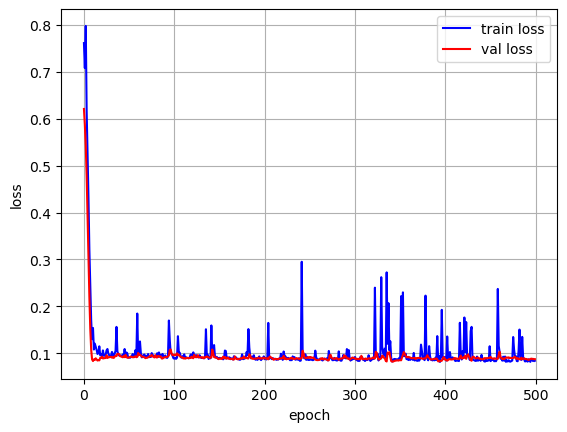

In [39]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [40]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(342, 0.0818193331625956)

In [27]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [28]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

In [29]:
np.array(trues_list).shape, np.array(preds_list).shape

((603, 1, 1), (603, 1, 1))

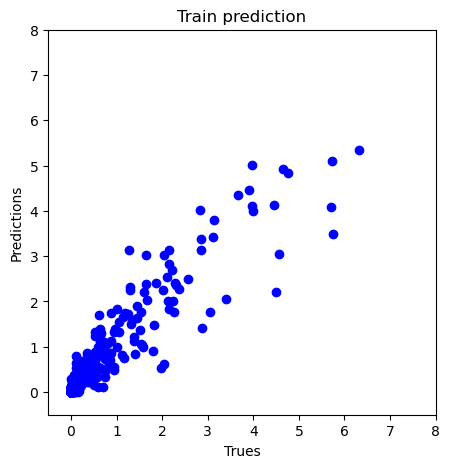

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [31]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

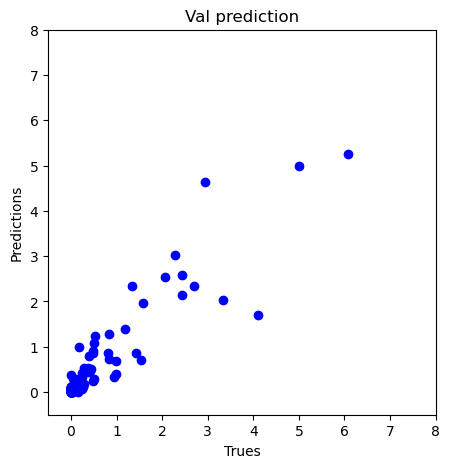

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [33]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [34]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [35]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [36]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [38]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [39]:
test_all_np.shape

(260, 4)

In [40]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [41]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [42]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [43]:
test_Xs = np.concatenate([test_Xs[:,:,0:1], test_Xs[:,:,-2:-1]], axis = 2)
test_ys = np.concatenate([test_ys[:,:,0:1], test_ys[:,:,-2:-1]], axis = 2)

In [44]:
tst_xs_tensor = torch.Tensor(test_Xs)
tst_ys_tensor = torch.Tensor(test_ys)

In [45]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [46]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


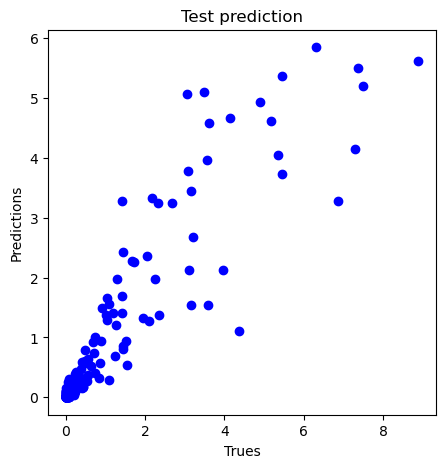

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [48]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [49]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

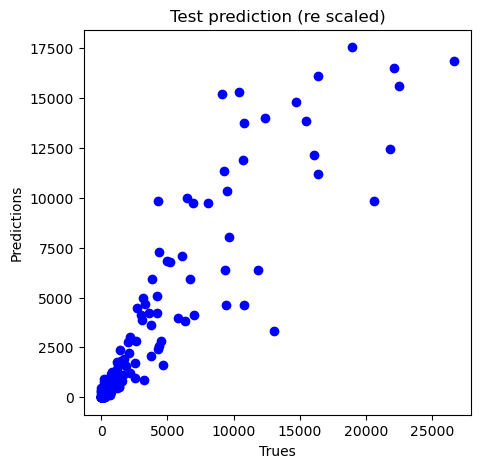

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [51]:
tst_preds.shape

(234, 1)

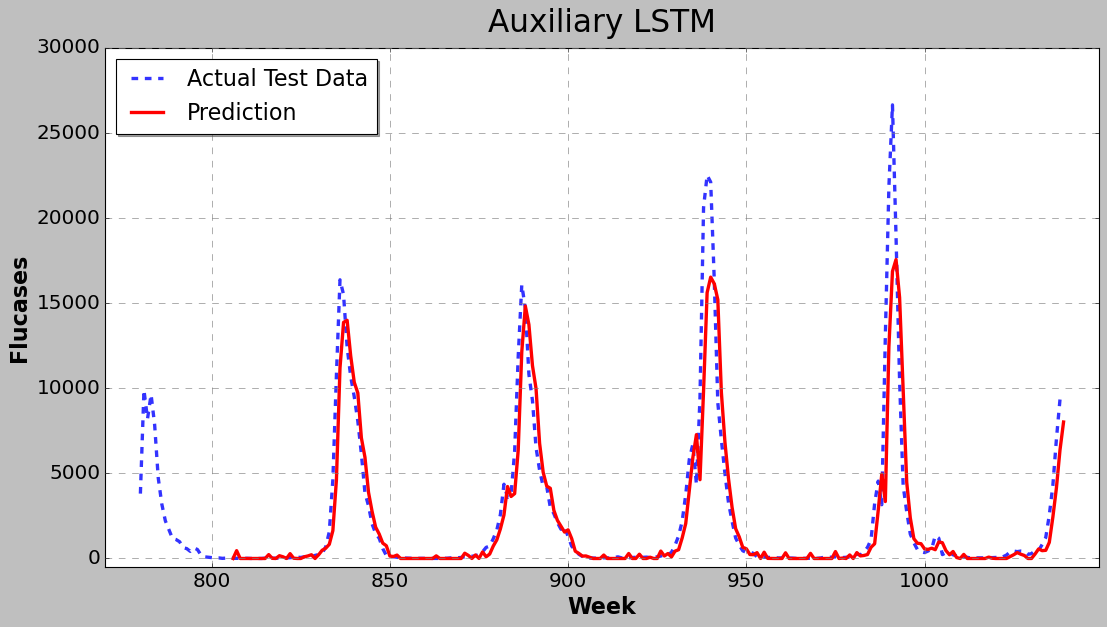

In [55]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=3, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=3, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Auxiliary LSTM", fontsize=28, y=1.02)

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.savefig("cLSTM.jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [67]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [68]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 3617875.9053909923.
RMSE : 1902.0714774663418.
MAE : 807.8171866602368.
R2 : 0.8361065655392548.
pearson : 0.9187100512106375 1.4078830382571897e-95


In [69]:
len(test_np[seq_length*2:,0]), len(tst_preds[seq_length:,0])

(208, 208)

In [70]:
reg_metric(test_np[seq_length*2:,0], tst_preds[seq_length:,0], "Flucases")

Flucases
MSE : 4068070.2801100714.
RMSE : 2016.9457801612.
MAE : 899.2264779496652.
R2 : 0.8312934028057655.
pearson : 0.9162658631050824 8.589458409575366e-84
